### The effect of different rheology on sea-ice breakup 

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 30 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

To test the impact of the BBM ice rheology formulation used in the neXtSIM simulations we performed additional experimemts with the "standard" EVP and mEVP rheologies. Aside from the rheology the experiments are identical to the standard WRF10 expt described in the manuscript. 

In [1]:
# allow plots to be interactive in the notebook
%matplotlib notebook
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import locale 
from pynextsim.projection_info import ProjectionInfo
import cmocean as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.colorbar import colorbar

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.


In [2]:
# plotting
def prepare_grid(ds):
    
    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent,
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,
        )

    return grid

def plot_nextsim(ax, grid, array, clevs, cmap, add_colorbar=True, **cbargs):
    
    cs = ax.contourf(array, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']],
             levels=clevs, cmap=cmap, **cbargs)

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="darkgrey")
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")
    ax.set_extent([-100, -50, 67, 87], ccrs.PlateCarree(central_longitude=300))

    # add colorbar 
    if add_colorbar:
        cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)

        out = plt.colorbar(cs, cax=cax, **cbargs)

<IPython.core.display.Javascript object>


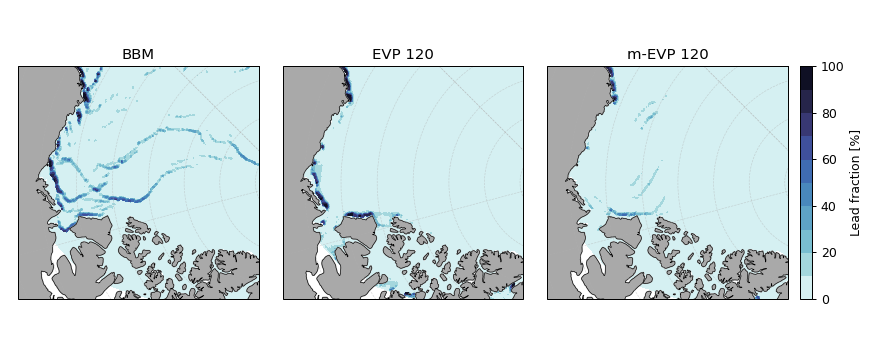

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


saving... /cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/leadfrac_beaufort_20130301_bbm_evp_mevp.png


In [17]:
outdir =  '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
rootdir = '/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/'
expts = ["expt_01_wrf10/outputs-v11/", "expt_01_wrf10-evp/outputs-120sc/", "expt_01_wrf10-mevp/outputs-120sc/"]
#expts = ["expt_02_wrf20/outputs/"]

expts_names = ["BBM", "EVP 120","m-EVP 120"]

files = [os.path.join(rootdir, f, 'Moorings.nc') for f in expts]

ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
ds2 = xr.open_dataset(files[2])

dslist = [ds0, ds1, ds2]

# Projection stuff
extent = [-110, 200, 67, 90]
proj = ProjectionInfo() # default nextsim projection
grid = prepare_grid(ds0)

# Plot lead fraction and ice velocity during the breakup

<IPython.core.display.Javascript object>


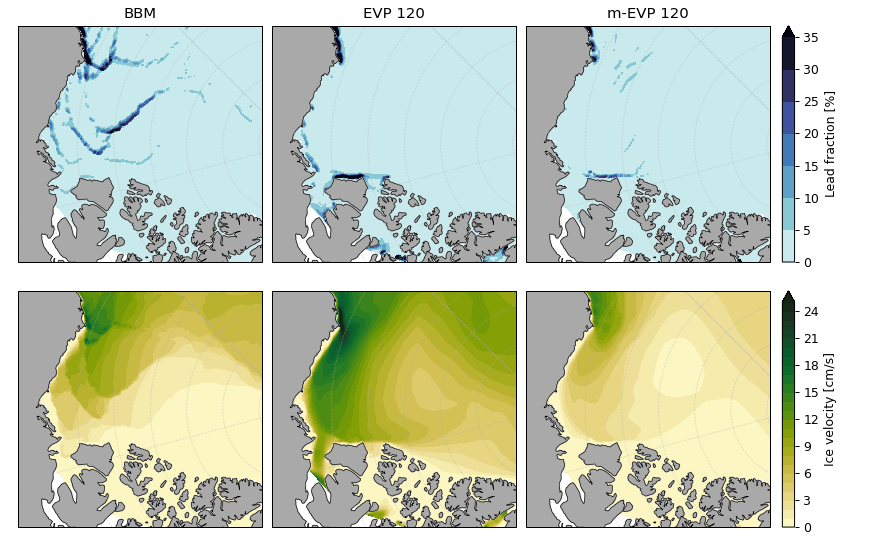

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


saving... /cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/leadfrac_icevel_beaufort_2013-02-18-2013-03-01_bbm_evp120_mevp120.png


In [19]:
plt.close('all')

# Make subplot    
fig, ax = plt.subplots(2,3, figsize=(10,6),
                       subplot_kw={'projection': grid['proj'].crs, 'extent': grid['extent']})

t1 = '2013-02-18'
t2 = '2013-03-01'

clevs = np.arange(0, 25+1, 1) 
cbargs0 = {"label": "Lead fraction [%]", "extend": "max"}
cbargs1 = {"label": "Ice velocity [cm/s]", "extend": "max"}

expts_names = ["BBM", "EVP 120","m-EVP 120"]
for i, ds in enumerate(dslist):

    # Compute lead fraction
    leadfrac = 1-ds['sic'] + ds['sic_thin']
    leadfrac = leadfrac.sel(time=slice(t1, t2)).mean(axis=0)*100 # in %
    
    # calculate ice velocity 
    ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    icevel = ds['icevel'].sel(time=slice(t1, t2)).mean(axis=0)*100 # in cm/s
      
    if i==2:
        plot_nextsim(ax[0,i], grid, leadfrac, np.arange(0, 40, 5) , cm.cm.ice_r, add_colorbar=True, **cbargs0)
        plot_nextsim(ax[1,i], grid, icevel, clevs, cm.cm.speed, add_colorbar=True, **cbargs1)
    else:
        plot_nextsim(ax[0,i], grid, leadfrac, np.arange(0, 40, 5) , cm.cm.ice_r, add_colorbar=False, **cbargs0)
        plot_nextsim(ax[1,i], grid, icevel, clevs, cm.cm.speed, add_colorbar=False, **cbargs1)

    # set titles
    datestr = dt.datetime.strftime(dto, "%Y-%m-%d")
    ax[0,i].set_title(expts_names[i])   


fig.subplots_adjust(bottom=0.01, top=0.96, left=0.02, right=0.86, wspace=0.04, hspace=0.08)
plt.show()

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s-%s_%s' % (outpath_plots, 'leadfrac_icevel_beaufort', t1, t2 ,'bbm_evp120_mevp120.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')  

When using the elastic-visco-plastic models the simulated velocity field is smoother compared to the BBM model and does not reproduce the observed fracturing.    

With BBM the ice cover consists of seperate ice floes that move at different speeds reletive to one-another. Small scale deformation features are also better resolved. 

Note that the resolution of the sea-ice model (and atm. forcing) is the same for all experiments. 
